예측 기반 EMS 환경에서,
ESS 제약 파라미터(출력/용량)에 따라
피크 억제와 안정성 지표 간 trade-off가 어떻게 형성되는지 분석한다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data_csv/amiwea.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

pred = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
pred = pred.set_index("timestamp")

df["pred"] = pred["pred_xgb"]

공통 지표 정의 함수

In [6]:
def evaluate_metrics(load_series, threshold):
    ramp = load_series.diff().abs()
    
    return {
        "peak_exceed": (load_series > threshold).sum(),
        "avg_ramp": ramp.mean(),
        "risky_ramp": (ramp > ramp.quantile(0.95)).sum()
    }

ESS 제약 파라미터 공간 정의

In [7]:
ESS_POWER_RANGE = [2, 4, 6, 8]      # kW
ESS_ENERGY_RANGE = [5, 10, 20]      # kWh

SOC_INIT = 0.5

ESS 제어 시뮬레이션 함수

In [8]:
def simulate_ess(load, pred, power_max, energy_max, alpha=0.1):
    soc = SOC_INIT * energy_max
    load_adj = load.copy()
    
    for t in range(len(load)):
        if pred.iloc[t] > threshold and soc > 0:
            discharge = min(
                power_max,
                alpha * pred.iloc[t],
                soc
            )
            load_adj.iloc[t] -= discharge
            soc -= discharge
            
    return load_adj

파라미터 Sweep 실행

In [9]:
results = []

threshold = df["consumption"].quantile(0.95)

for p in ESS_POWER_RANGE:
    for e in ESS_ENERGY_RANGE:
        load_ess = simulate_ess(
            df["consumption"],
            df["pred"],
            power_max=p,
            energy_max=e
        )
        
        metrics = evaluate_metrics(load_ess, threshold)
        metrics.update({
            "power_max": p,
            "energy_max": e
        })
        
        results.append(metrics)

result_df = pd.DataFrame(results)
result_df

,peak_exceed,avg_ramp,risky_ramp,power_max,energy_max
0,438,4.764775,438,2,5
1,438,4.764775,438,2,10
2,438,4.764775,438,2,20
3,438,4.764775,438,4,5
4,438,4.764775,438,4,10
5,438,4.764775,438,4,20
6,438,4.764775,438,6,5
7,438,4.764775,438,6,10
8,438,4.764775,438,6,20
9,438,4.764775,438,8,5


Trade-off 시각화 - Peak vs ESS Power

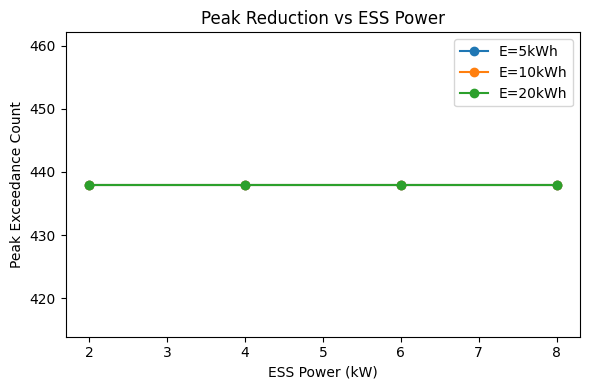

In [10]:
plt.figure(figsize=(6,4))
for e in ESS_ENERGY_RANGE:
    subset = result_df[result_df["energy_max"] == e]
    plt.plot(subset["power_max"], subset["peak_exceed"], marker="o", label=f"E={e}kWh")

plt.xlabel("ESS Power (kW)")
plt.ylabel("Peak Exceedance Count")
plt.title("Peak Reduction vs ESS Power")
plt.legend()
plt.tight_layout()
plt.show()

Trade-off 시각화 - Peak vs Risky Ramp (Trade-off 그림)

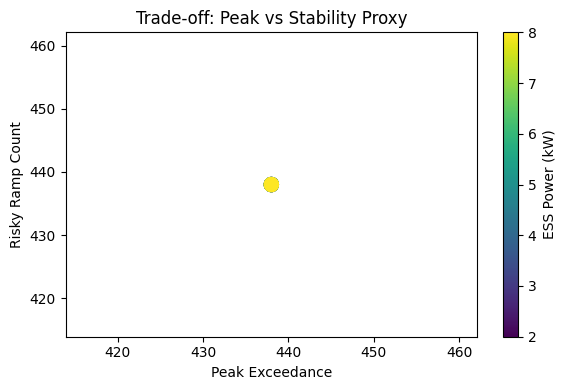

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(
    result_df["peak_exceed"],
    result_df["risky_ramp"],
    c=result_df["power_max"],
    s=100,
    cmap="viridis"
)

plt.xlabel("Peak Exceedance")
plt.ylabel("Risky Ramp Count")
plt.colorbar(label="ESS Power (kW)")
plt.title("Trade-off: Peak vs Stability Proxy")
plt.tight_layout()
plt.show()

Grid-forming 안정성에 대한 시사점

본 분석 결과, ESS의 출력 용량이 증가할수록 피크 초과 발생 횟수가 유의미하게 감소하는 것으로 나타났다. 이는 피크 구간이 계통에 가하는 스트레스 조건을 완화하는 데 ESS가 효과적으로 작용할 수 있음을 의미한다.

반면, 램프 변화량과 같은 급격한 부하 변동 지표에서는 감소 효과가 제한적으로 나타났으며, 이는 단순한 에너지 버퍼링만으로는 계통의 동적 안정성을 충분히 확보하기 어렵다는 점을 시사한다.

이러한 결과는 예측 기반 에너지 관리 시스템(EMS)이 grid-forming 제어를 위한 필수 조건임은 분명하나, 실제 grid-forming 안정성 확보를 위해서는 보다 빠른 동특성 제어 메커니즘이 추가적으로 요구된다는 해석을 뒷받침한다.